In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style("whitegrid")

### PPD data
https://www.gov.uk/government/statistical-data-sets/price-paid-data-downloads

In [2]:
ppd=pd.read_csv('pp-monthly-update-new-version.csv', header=None, prefix='X') #read in lastest property sales data
ppd.shape # see dimensions of data set

(100789, 16)

In [3]:
ppd['postcode_district']=ppd['X3'].str.split(' ').str[0].tolist()
ppd['X2']=pd.to_datetime(ppd['X2'])
ppd['yyyy']=ppd['X2'].map(lambda x: x.to_pydatetime().year)
ppd['mm']=ppd['X2'].map(lambda x: x.to_pydatetime().month)
ppd['yyyymm']=ppd['X2'].dt.strftime('%Y%m')
ppd = ppd.drop(columns=['X0','X14','X15']) #see top rows of data set
ppd.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,postcode_district,yyyy,mm,yyyymm
0,380000,2006-06-30,BS40 8BG,D,N,F,WAPSELL COTTAGE,NaN,UPPER STRODE,WINFORD,BRISTOL,NORTH SOMERSET,NORTH SOMERSET,BS40,2006,6,200606
1,130000,2006-08-10,LL28 4RU,F,N,L,18A,NaN,WOODLANDS AVENUE,RHOS ON SEA,COLWYN BAY,CONWY,CONWY,LL28,2006,8,200608
2,282500,2006-07-14,TQ13 7NH,T,N,F,4,NaN,GOLDEN LION COURT,ASHBURTON,NEWTON ABBOT,TEIGNBRIDGE,DEVON,TQ13,2006,7,200607
3,237000,2006-06-08,DT2 7DB,S,N,F,IVY BARN COTTAGE,NaN,NaN,BUCKLAND NEWTON,DORCHESTER,DORSET,DORSET,DT2,2006,6,200606
4,125000,2006-01-24,DT11 0SP,T,N,F,2,NaN,MAYPOLE TERRACE,SHILLINGSTONE,BLANDFORD FORUM,DORSET,DORSET,DT11,2006,1,200601


In [4]:
# cols = [ 'Price', 'Date', 'Postcode', 'Type', 'New?', 'Leasehold?', 'PAON', 'SAON', 'Street', 'Locality', 'Town', 'District', 
#          'County', 'PPD Category', 'Record Status']

* name of the street is popular
* flat vs. cottage

In [5]:
ppd['X12'].value_counts()

BIRMINGHAM         1495
LEEDS              1461
CORNWALL           1188
COUNTY DURHAM      1018
LIVERPOOL           939
                   ... 
ISLES OF SCILLY       5
EAST DORSET           1
POOLE                 1
COLWYN                1
PURBECK               1
Name: X12, Length: 343, dtype: int64

In [6]:
ppd['postcode2'] =  ppd['X3'].str.split(' ').str[0] + ' ' + ppd['X3'].str.split(' ').str[1].str[0]

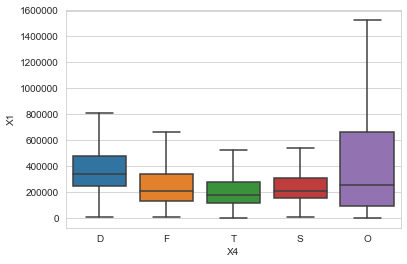

In [7]:
sns.boxplot(ppd['X4'], ppd['X1'], showfliers=False)

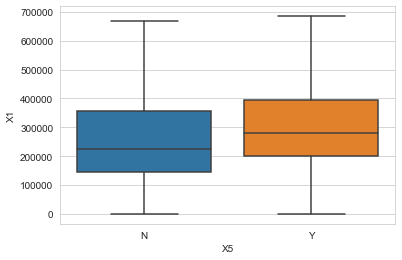

In [8]:
sns.boxplot(ppd['X5'], ppd['X1'], showfliers=False)

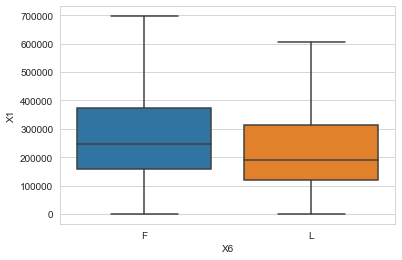

In [9]:
sns.boxplot(ppd['X6'], ppd['X1'], showfliers=False)

In [10]:
ppd = ppd.join(pd.get_dummies(ppd['X4']))

In [11]:
ppd['New?'] = 0
ppd.loc[ppd['X5']=='Y', 'New?'] = 1

In [12]:
ppd['Lease?'] = 0
ppd.loc[ppd['X6']=='L', 'Lease?'] = 1

In [13]:
ppd.shape

(100789, 25)

In [14]:
from sklearn.feature_extraction import FeatureHasher

In [15]:
len(ppd['postcode2'].unique())

7913

In [16]:
ppd['postcode2'] = ppd['postcode2'].astype(str)

In [17]:
h = FeatureHasher(n_features=100, input_type='string')
pc_hash = h.fit_transform(ppd['postcode2'])

In [18]:
pc_hash_cols = ['PC_hash_'+str(t) for t in range(pc_hash.shape[1])]

In [19]:
ppd = ppd.join(pd.DataFrame(pc_hash.toarray(), index=ppd.index, columns=pc_hash_cols))

In [20]:
good_columns = ['D', 'F', 'T', 'S', 'O', 'New?', 'Lease?', 'yyyymm'] + pc_hash_cols

In [21]:
X = ppd[good_columns].copy()
y = ppd['X1'].copy()

In [22]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [24]:
regr = RandomForestRegressor(max_depth=8,n_estimators=300, n_jobs=-1)
# regr = LinearRegression()

In [25]:
model = regr.fit(X_train, y_train)

In [26]:
model.score(X_train, y_train)

0.6034112100414495

In [27]:
y_train_pred = model.predict(X_train)

In [28]:
r2_score(y_train, y_train_pred)

0.6034112100414497

In [29]:
y_test_pred = model.predict(X_test)

In [30]:
r2_score(y_test, y_test_pred)

-0.3856449978165717

In [31]:
from sklearn.model_selection import cross_val_score

In [32]:
# np.mean(cross_val_score(regr, X, y, cv=5))

In [ ]:
# ppd.head().T

In [ ]:
# cols = [ 'Price', 'Date', 'Postcode', 'Type', 'New?', 'Leasehold?', 'PAON', 'SAON', 'Street', 'Locality', 'Town', 'District', 
#          'County', 'PPD Category', 'Record Status']

In [ ]:
ppd.groupby('postcode_district')['X1'].agg('count').sort_values(ascending=False).head()

In [ ]:
ppd.loc[ppd['postcode_district']=='M5', 'X1'].clip(0,1e7).hist(bins=50)

In [ ]:
ppd.groupby('postcode_district')['X1'].agg('mean').reset_index()